<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
from google.colab import files
uploaded = files.upload()


import pandas as pd
from PIL import Image
from torchvision import transforms
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Saving dev_df_images.json to dev_df_images.json
Saving train_df_images.json to train_df_images.json


In [ ]:
train_df_images = pd.read_json('train_df_images.json', orient="records", lines=True)
dev_df_images = pd.read_json('dev_df_images.json', orient="records", lines=True)

In [ ]:
# Clean the labels (see notebook cleaning data for more details)

# Select the labels and associated labels to correct
to_correct = train_df_images[train_df_images["label"].isin(['cultural agn','cultural represent', 'cultural ex', 'cultural ag'])][['item', 'label']]

# Create the mapping for correction
mapping_correction = {
  'cultural agn' : 'cultural agnostic',
  'cultural represent' : 'cultural representative',
  'cultural ex' : 'cultural exclusive',
  'cultural ag' : 'cultural agnostic'
}

# Apply the correction
to_correct['label'] = to_correct['label'].map(mapping_correction)

# We update the transformations to the initial dataset
train_df_images.set_index('item', inplace=True)
to_correct.set_index('item', inplace=True)

train_df_images.update(to_correct)
train_df_images.reset_index(inplace=True)

In [ ]:
# Select the items that have no label, or with label 'cultural', or 'cult'
to_classify = train_df_images[(train_df_images["label"].isin(["cultural", "cult"])) | (train_df_images["label"].isna())][['item', 'name', 'description']]

# Create the dictionnary for the mapping
categories = {
    'http://www.wikidata.org/entity/Q957033': 'cultural representative',
    'http://www.wikidata.org/entity/Q30327019': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q811361': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q12014207': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q257907': 'cultural exclusive',
    'http://www.wikidata.org/entity/Q1136336': 'cultural representative',
    'http://www.wikidata.org/entity/Q67111': 'cultural representative',
    'http://www.wikidata.org/entity/Q1089672': 'cultural representative',
    'http://www.wikidata.org/entity/Q85755629': 'cultural representative',
    'http://www.wikidata.org/entity/Q206912': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q23228': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q3196604': 'cultural representative',
    'http://www.wikidata.org/entity/Q1940624': 'cultural representative'
}

# Apply the classification
to_classify['label'] = to_classify['item'].map(categories)

# We update the transformations to the initial dataset
train_df_images.set_index('item', inplace=True)
to_classify.set_index('item', inplace=True)

train_df_images.update(to_classify)
train_df_images.reset_index(inplace=True)

In [ ]:
# Mapping labels to integers
labels = train_df_images['label'].unique()
dict_mapping ={}

for i, label in enumerate(labels):
  dict_mapping[label]=int(i)
  i = i+1

print(dict_mapping)

for df in [train_df_images, dev_df_images]:
  df['label'] = df['label'].map(dict_mapping)
  df['label'] = df['label'].apply(lambda x: np.array(x))

{'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}


Now, we keep the following association : {cultural exclusive: 0, cultural representative: 1, cultural agnostic: 2}

## Fill in or drop

Some photos are missing for many items, and as the CNN can not handles missing values, we have to find solutions to deal with this problem. We have for now 2 options :

- Fill in the NaN with white images
- Drop the item with missing image

In [ ]:
def fill_NaN_image(image):

  """
  If a cell is empty, it fills in with a white image, of dimension (28,28,3) ie (height, width, channels)
  """

  if image is None or (isinstance(image, float) and np.isnan(image)):
    image = np.ones((28, 28, 3), dtype=np.uint8) * 255

  return image

In [ ]:
def clean_images(df, fill=True, drop=False):

  if fill == True:
    df['image'] = df['image'].apply(lambda x: fill_NaN_image(x))

  if drop == True:
    df = df[df['image'].notna()]

  return df

In [ ]:
# Create a dataframe where we only keep the item that have an image
train_df_images_without_na = clean_images(train_df_images, fill=False, drop=True)
dev_df_images_without_na = clean_images(dev_df_images, fill=False, drop=True)


# Create a dataframe where we keep all the image, and fill in the NaN with white images
train_df_images_fill = clean_images(train_df_images, fill=True, drop=False)
dev_df_images_fill = clean_images(dev_df_images, fill=True, drop=False)

In [ ]:
# Transform data to arrays
train_df_images_without_na['image'] = train_df_images_without_na['image'].apply(lambda x: np.array(x))
dev_df_images_without_na['image'] = dev_df_images_without_na['image'].apply(lambda x: np.array(x))

train_df_images_fill['image'] = train_df_images_fill['image'].apply(lambda x: np.array(x))
dev_df_images_fill['image'] = dev_df_images_fill['image'].apply(lambda x: np.array(x))

<ipython-input-13-ce936c5b28cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_images_without_na['image'] = train_df_images_without_na['image'].apply(lambda x: np.array(x))
<ipython-input-13-ce936c5b28cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df_images_without_na['image'] = dev_df_images_without_na['image'].apply(lambda x: np.array(x))


## Model 1 : fill in model

First, we try the model applied on the dataset wherre we filled in the missing values by white images

We want to train a model, that is able to classify our items, into the 3 classes of culture. So we create a model called model_classification for that. But we also want to get the logits of this model (the output of the layer just before the softmax layer), so that we can use this information, in a bigger model (we call it the ensemble model) : that's the reason why, we create also the model called model_logits

### Training and accuracy

In [ ]:
# We create two models
model_classification = models.Sequential()
model_logits = models.Sequential()

# Build the layers
layer_conv1 = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3))
layer_maxpool = layers.MaxPooling2D((2, 2))

layer_conv2 = layers.Conv2D(64, (3, 3), activation='relu')
layer_maxpool2 = layers.MaxPooling2D((2, 2))

layer_flatten = layers.Flatten()
layer_dense_1 = layers.Dense(64, activation='relu')
layer_dropout = layers.Dropout(0.3)
layer_logits = layers.Dense(3, name="logits")  # dense finale sans activation
layer_softmax = layers.Activation('softmax', name="softmax")  # activation séparée

# Fill in the models with layers (almost the same)
model_logits.add(layer_conv1)
model_logits.add(layer_maxpool)
model_logits.add(layer_conv2)
model_logits.add(layer_maxpool2)
model_logits.add(layer_flatten)
model_logits.add(layer_dense_1)
model_logits.add(layer_logits)

model_classification.add(layer_conv1)
model_classification.add(layer_maxpool)
model_classification.add(layer_conv2)
model_classification.add(layer_maxpool)
model_classification.add(layer_flatten)
model_classification.add(layer_dense_1)
model_classification.add(layer_logits)
model_classification.add(layer_softmax)

# Compilation
model_classification.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

# Images normalization
X_train_fill = np.stack(train_df_images_fill['image'].to_numpy()).astype('float32') / 255.0
y_train_fill = train_df_images_fill['label']

X_dev_fill = np.stack(dev_df_images_fill['image'].to_numpy()).astype('float32') / 255.0
y_dev_fill = dev_df_images_fill['label']

# Training
model_classification.fit(X_train_fill, y_train_fill, epochs=40, batch_size=32)

# Evaluation
train_loss, train_accuracy = model_classification.evaluate(X_train_fill, y_train_fill)
dev_loss, dev_accuracy = model_classification.evaluate(X_dev_fill, y_dev_fill)

print(f"Accuracy on the train set : {train_accuracy:.4f}")
print(f"Accuracy on the dev set : {dev_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4301 - loss: 1.0465
Epoch 2/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4599 - loss: 1.0057
Epoch 3/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4721 - loss: 1.0056
Epoch 4/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4780 - loss: 0.9849
Epoch 5/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4679 - loss: 0.9810
Epoch 6/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4842 - loss: 0.9735
Epoch 7/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4945 - loss: 0.9553
Epoch 8/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5264 - loss: 0.9412
Epoch 9/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5297 - loss: 0.9222
Epoch 10/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5612 - loss: 0.8879
Epoch 11/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5502 - loss: 0.8759
Epoch 12/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

### A deeper analysis of the performance

In [ ]:
# Get the logit output from the dev set
dev_logits = model_logits.predict(X_dev_fill)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(300, 3)

In [ ]:
# Get the logit output from the train set
train_logits = model_logits.predict(X_train_fill)

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(6251, 3)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


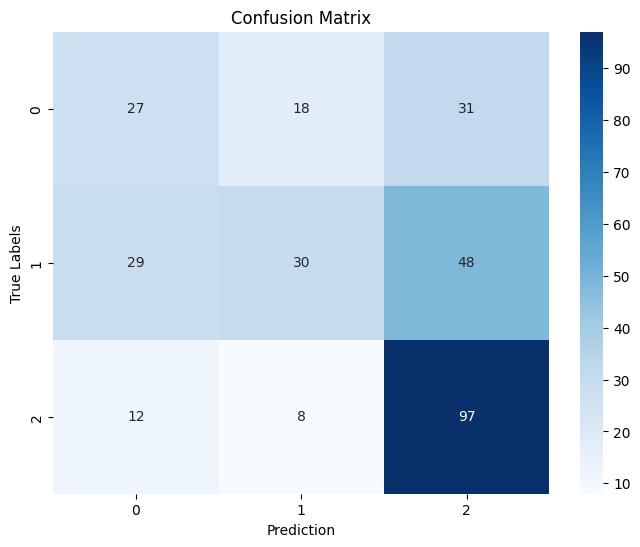

In [ ]:
# Prepare the data to evaluate the model
y_pred = model_classification.predict(X_dev_fill)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_dev_fill, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Compute Precision, Recall, and F1-score
precision = precision_score(y_dev_fill, y_pred_classes, average='macro')
recall = recall_score(y_dev_fill, y_pred_classes, average='macro')
f1 = f1_score(y_dev_fill, y_pred_classes, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# More complete informations
print("\n")
print(classification_report(y_dev_fill, y_pred_classes))


Precision : 0.4946
Recall : 0.4882
F1 Score : 0.4684


              precision    recall  f1-score   support

           0       0.40      0.36      0.38        76
           1       0.54      0.28      0.37       107
           2       0.55      0.83      0.66       117

    accuracy                           0.51       300
   macro avg       0.49      0.49      0.47       300
weighted avg       0.51      0.51      0.48       300



## Exportation

In [ ]:
from huggingface_hub import login, create_repo, upload_folder
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download

login(token="")

repo_name = "MNLP-HW1"
repo_id = f"tgarnier067/{repo_name}"
create_repo(repo_id, exist_ok=True, private=False)
model_folder = "models"
os.makedirs(model_folder, exist_ok=True)
models = {
    "model_logits_photos": model_logits
}

# Save the models in separate files
for model_name, model in models.items():
    model_file_path = os.path.join(model_folder, f"{model_name}.keras")
    model.save(model_file_path)

# Add a default README
readme_content = """# MNLP HW1 Models
This repository contains multiple models trained for different tasks. Each model is saved as a separate `.keras` file.
"""

# Create a README.md file in the model folder
with open(os.path.join(model_folder, "README.md"), "w") as f:
    f.write(readme_content)

# Upload all models to the Hugging Face repo
upload_folder(
    repo_id=repo_id,
    folder_path=model_folder,
    path_in_repo=""
)

print(f"All models have been successfully uploaded to Hugging Face in the repo {repo_id}!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9561: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_logits_photos.keras:   0%|          | 0.00/517k [00:00<?, ?B/s]

All models have been successfully uploaded to Hugging Face in the repo tgarnier067/MNLP-HW1!


## Model 2 : Without na

Now, we try the same model, but based on the non missing values dataset only

In [ ]:
def build_a_model(input_shape=(28, 28, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_without_na = build_a_model()

# Normalization so that the fitting of the CNN is easier
X_train_without_na= np.stack(train_df_images_without_na['image'].to_numpy()).astype('float32') / 255.0
y_train_without_na = train_df_images_without_na['label']
X_dev_without_na = np.stack(dev_df_images_without_na['image'].to_numpy()).astype('float32') / 255.0
y_dev_without_na = dev_df_images_without_na['label']

# Fitting
model_without_na.fit(X_train_without_na, y_train_without_na, epochs=40, batch_size=32)

# Evaluation, on both sets
train_loss, train_accuracy = model_without_na.evaluate(X_train_without_na, y_train_without_na)
dev_loss, dev_accuracy = model_without_na.evaluate(X_dev_without_na, y_dev_without_na)

print(f"Accuracy on the train set : {train_accuracy:.4f}")
print(f"Accuracy on the dev set : {dev_accuracy:.4f}")

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4541 - loss: 1.4221
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5013 - loss: 1.0073
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4839 - loss: 0.9903
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5003 - loss: 0.9680
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5375 - loss: 0.9276
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5371 - loss: 0.9321
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5432 - loss: 0.9377
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5403 - loss: 0.9127
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5498 - loss: 0.8945
Epoch 10/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5705 - loss: 0.8983
Epoch 11/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5557 - loss: 0.8990
Epoch 12/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5608 - loss: 0.9003

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


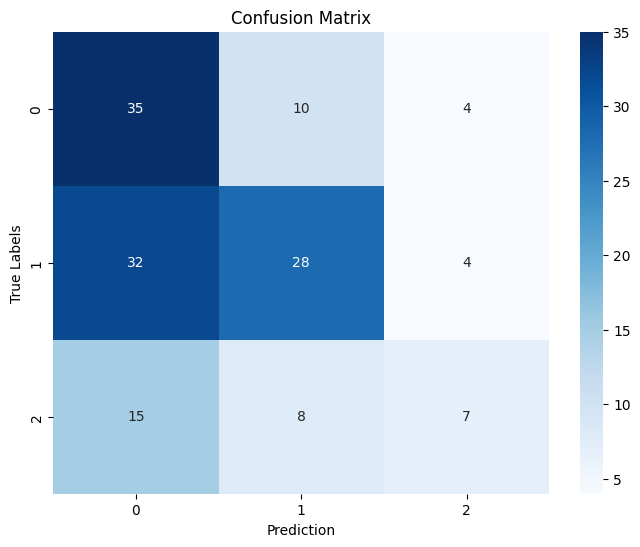

In [ ]:
# Prepare the data for evaluation
y_pred = model_without_na.predict(X_dev_without_na)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_dev_without_na, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Compute Precision, Recall, and F1-score (in mean macro)
precision = precision_score(y_dev_without_na, y_pred_classes, average='macro')
recall = recall_score(y_dev_without_na, y_pred_classes, average='macro')
f1 = f1_score(y_dev_without_na, y_pred_classes, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# More complete informations
print("\n")
print(classification_report(y_dev_without_na, y_pred_classes))

Precision : 0.5007
Recall : 0.4617
F1 Score : 0.4515


              precision    recall  f1-score   support

           0       0.43      0.71      0.53        49
           1       0.61      0.44      0.51        64
           2       0.47      0.23      0.31        30

    accuracy                           0.49       143
   macro avg       0.50      0.46      0.45       143
weighted avg       0.52      0.49      0.48       143

